# Imports

In [2]:
import pandas as pd
import pyarrow as pa
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
string_list_type = pa.list_(pa.string())
df = pd.read_orc('data/sent_1.orc', dtype_backend='pyarrow')
df

,init_words,mod_words,pos_tags
0,['ჩამოჯდება' '.'],['ჩამოჯდება' '.'],['V' 'Punct']
1,['სკამს' 'შემოატრიალებს' '.'],['სკამს' 'შემოატრიალებს' '.'],['N' 'V' 'Punct']
2,['სიგარეტს' 'საფერფლეში' 'ჩაჭყლეტს' '.'],['სიგარეტს' 'საფერფლეში' 'ჩაჭყლეტს' '.'],['N' 'N' 'V' 'Punct']
3,['ავანსცენისკენ' 'წამოვა' '.'],['ავანსცენისკენ' 'წამოვა' '.'],['N' 'V' 'Punct']
4,['მოტრიალდება' '.'],['მოტრიალდება' '.'],['V' 'Punct']
...,...,...,...
99995,['ისიც' 'ჩემს' 'წინ' 'დადგა' '.'],['ისიც' 'ჩემს' 'წინ' 'დადგა' '.'],['Pron' 'Pron' 'Pp' 'V' 'Punct']
99996,['უკვე' 'დარბაზიც' 'შევუკვეთეთ' '…' 'რას' 'იტყ...,['უკვე' 'დარბაზიც' 'შევუკვეთეთ' '…' 'რას' 'იტყ...,['Adv' 'N' 'V' 'Punct' 'Pron' 'V' 'Punct']
99997,"['მერედა' 'რა' 'გამოვიდა' 'იქედან' ',' 'რომ' '...","['მერედა' 'რა' 'გამოვიდა' 'იქედან' ',' 'რომ' '...",['Adv' 'Pron' 'V' 'Adv' 'Punct' 'Cj' 'V' 'Punc...
99998,['და' 'არაფერი' 'მიამბე' '!'],['და' 'არაფერი' 'მიამბე' '!'],['Cj' 'Pron' 'V' 'Punct']


In [14]:
df['length'] = df.pos_tags.apply(lambda l: len(l))

<Axes: xlabel='pos_tags', ylabel='count'>

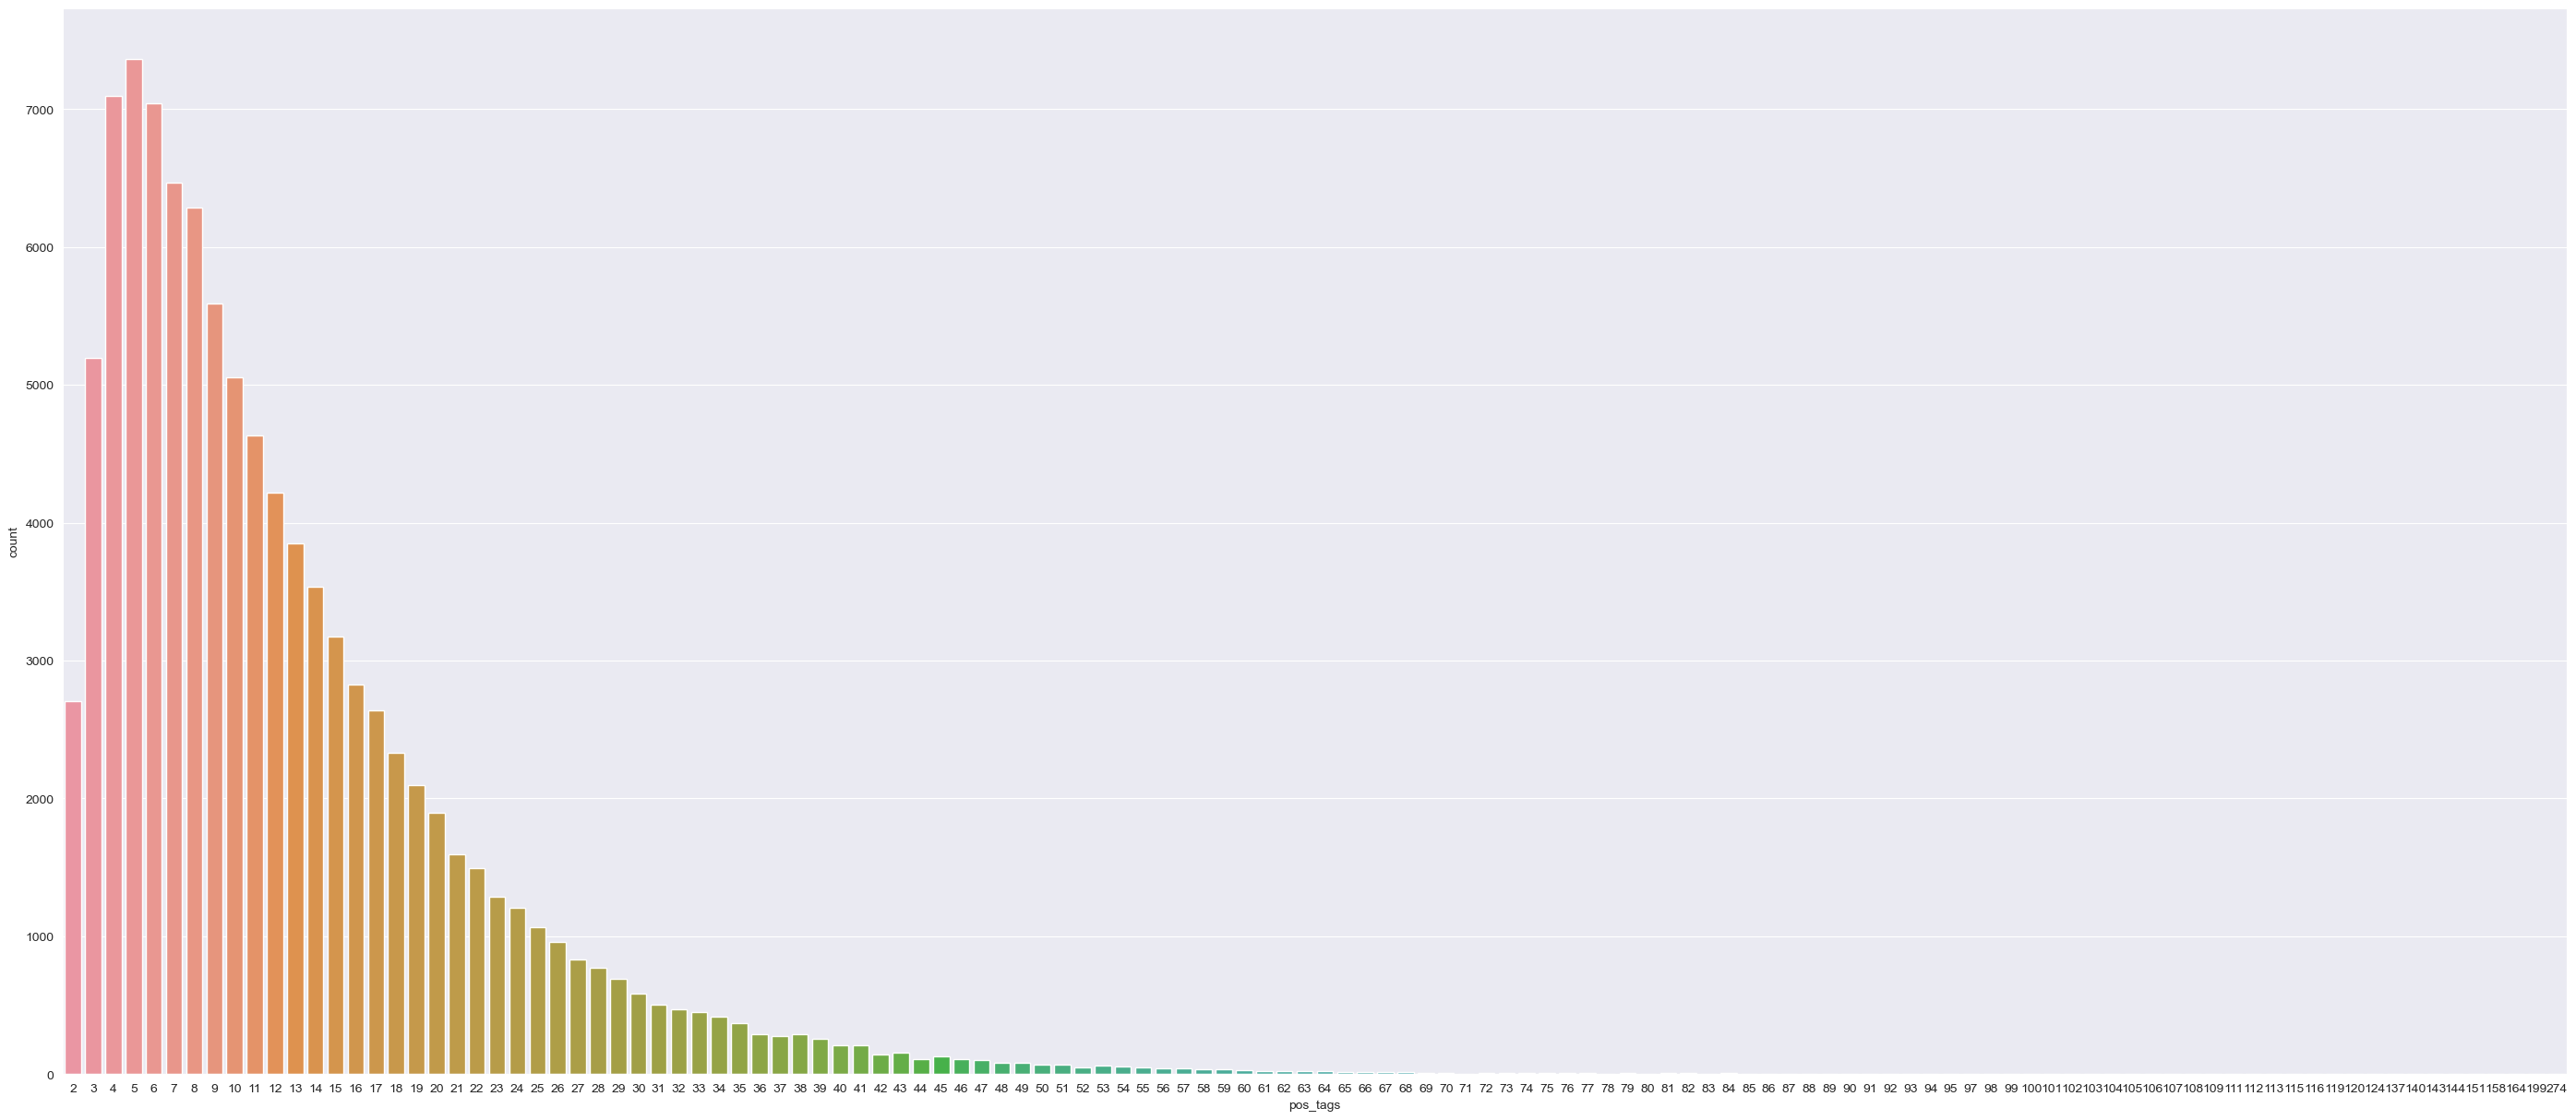

In [13]:
plt.figure(figsize=(35, 15))
sns.countplot(x=df.pos_tags.apply(lambda l: len(l)))

In [5]:
pos_tags_statistics = df.pos_tags.apply(lambda l: pd.Series(l).value_counts()).fillna(0)  # counts of pos tags per sentence

<Axes: >

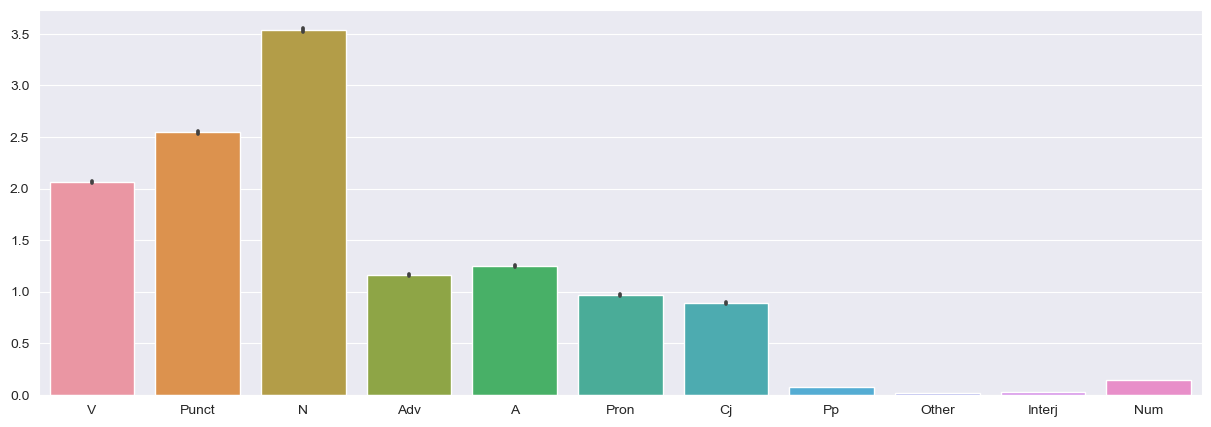

In [6]:
plt.figure(figsize=(15, 5))
sns.barplot(pos_tags_statistics)

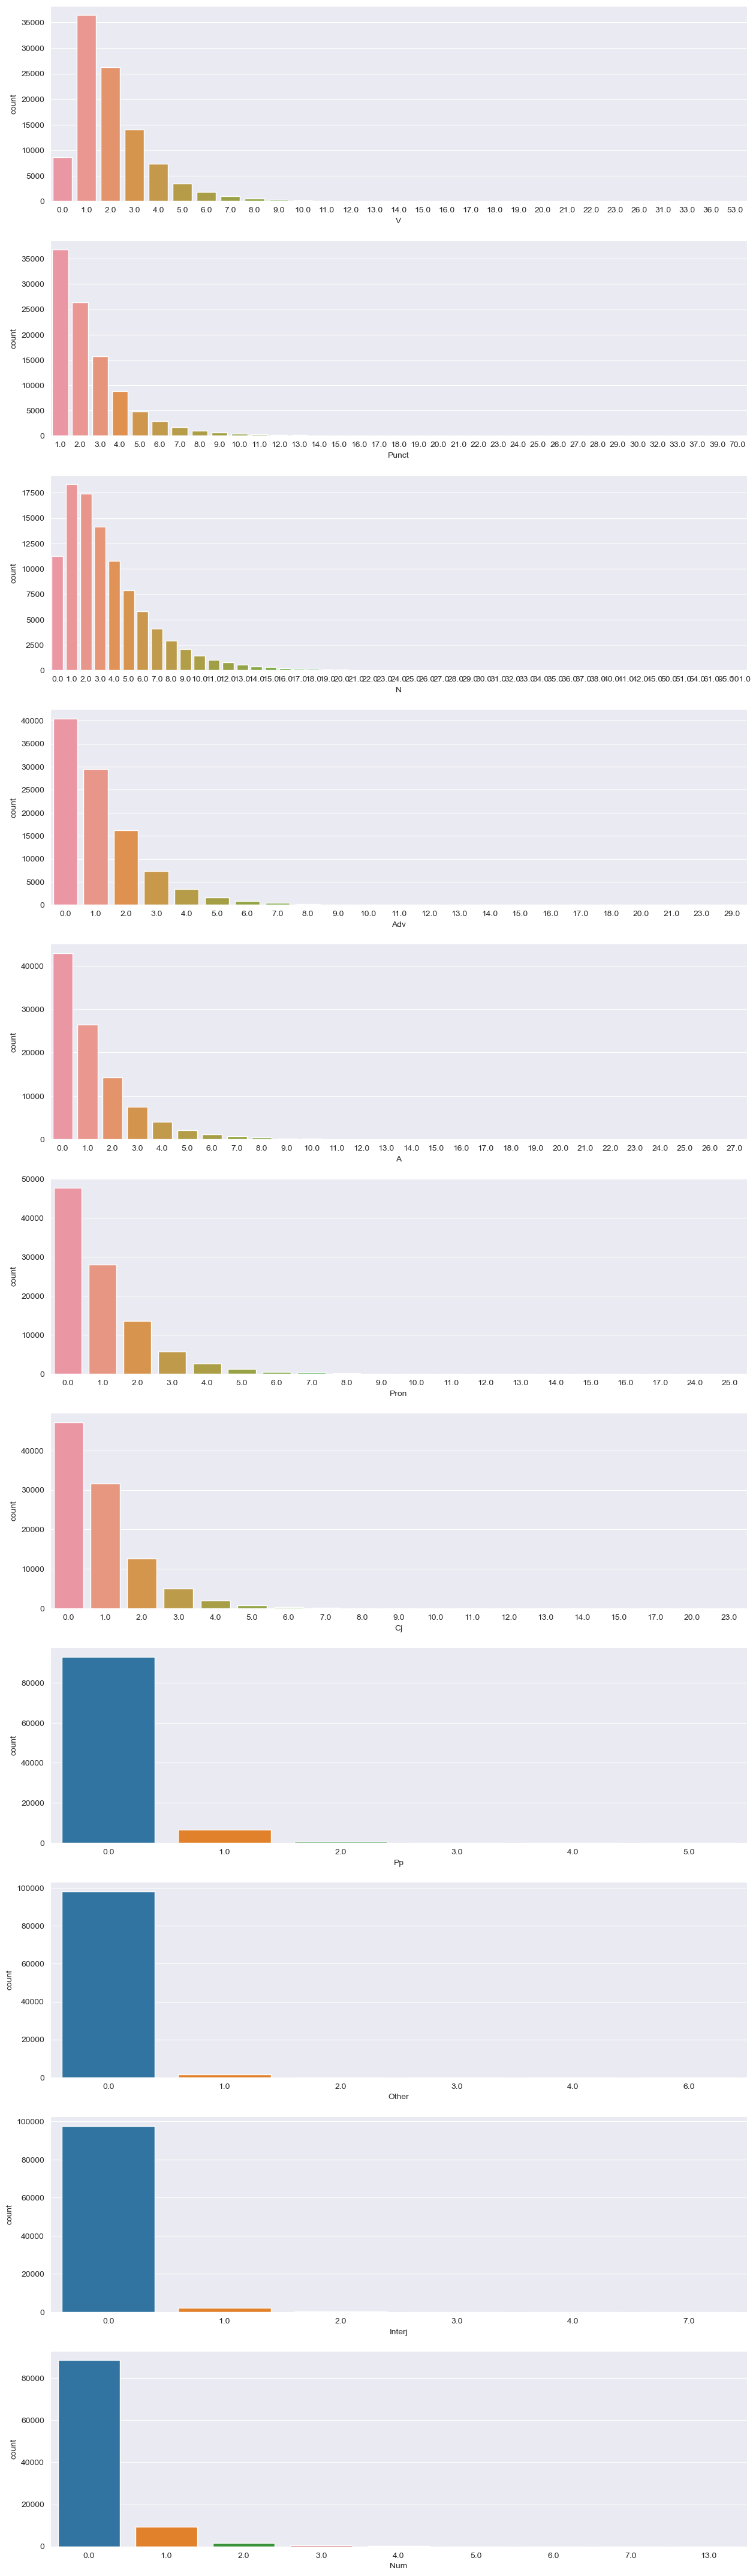

In [7]:
pos_tags = pos_tags_statistics.columns
fig, axs = plt.subplots(nrows=len(pos_tags), figsize=(15, 5 * len(pos_tags)))
for idx, pos_tag in enumerate(pos_tags):
    sns.countplot(pos_tags_statistics, x=pos_tag, ax=axs[idx])

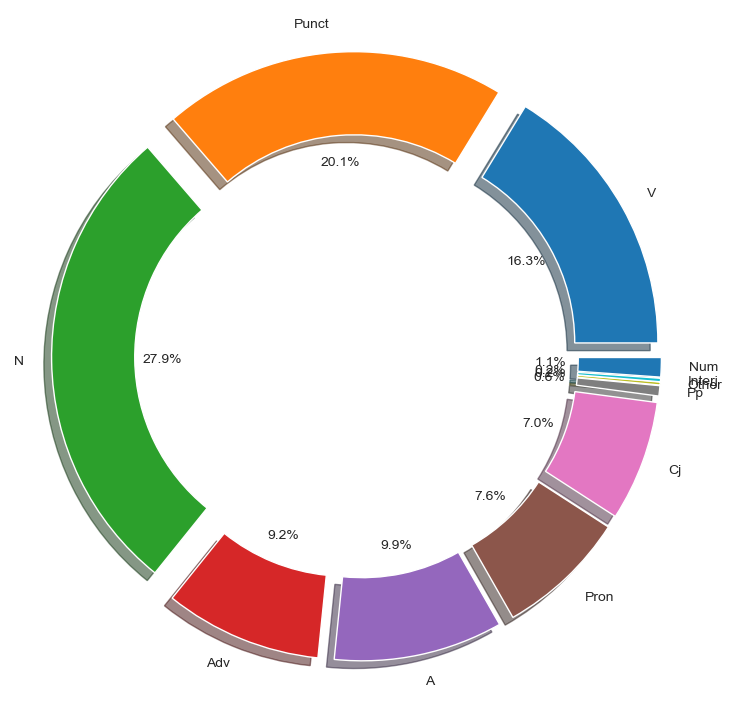

In [22]:
plt.figure(figsize=(9, 9))
dist = pos_tags_statistics.sum(axis=0)/ pos_tags_statistics.sum(axis=0).sum()
explode = ([0.1] * len(dist))
plt.pie(list(dist), labels=dist.index, explode=explode, shadow=True, autopct='%1.1f%%', wedgeprops=dict(width=0.3))
plt.show()

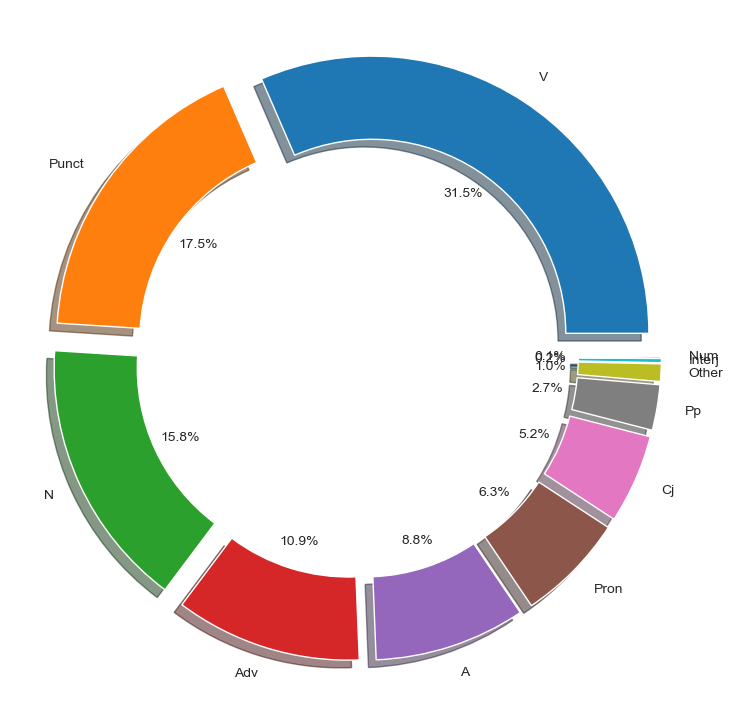

In [23]:
plt.figure(figsize=(9, 9))
first_pos_dist = df.pos_tags.apply(lambda l: l[0]).value_counts() / df.pos_tags.count()
explode = ([0.1] * len(first_pos_dist))
plt.pie(list(first_pos_dist), labels=dist.index, explode=explode, shadow=True, autopct='%1.1f%%', wedgeprops=dict(width=0.3))
plt.show()

In [25]:
def get_transitions(df: pd.DataFrame, column:str ):
    initial_counts: pd.DataFrame = df[column].apply(lambda x: x[0]).value_counts() / df[column].count()

    pairs: pd.DataFrame = df[column].apply(lambda x: [(x[i], x[i + 1]) for i in range(len(x) - 1)]).explode().apply(lambda x: pd.Series([x[0], x[1]]))

    transitions: pd.DataFrame = pairs.groupby([0, 1]).size().reset_index(name='counts')
    transitions['probability'] = transitions.groupby([0]).apply(lambda x: x['counts'] / x['counts'].sum()).reset_index(name='probability')['probability']

    transitions_mapping = {first: {row[1]: row['probability'] for row in ser1.iloc} for first, ser1 in transitions.groupby(0)}

    return initial_counts.to_dict(), transitions_mapping



In [27]:
initial, transitions = get_transitions(df, 'pos_tags')

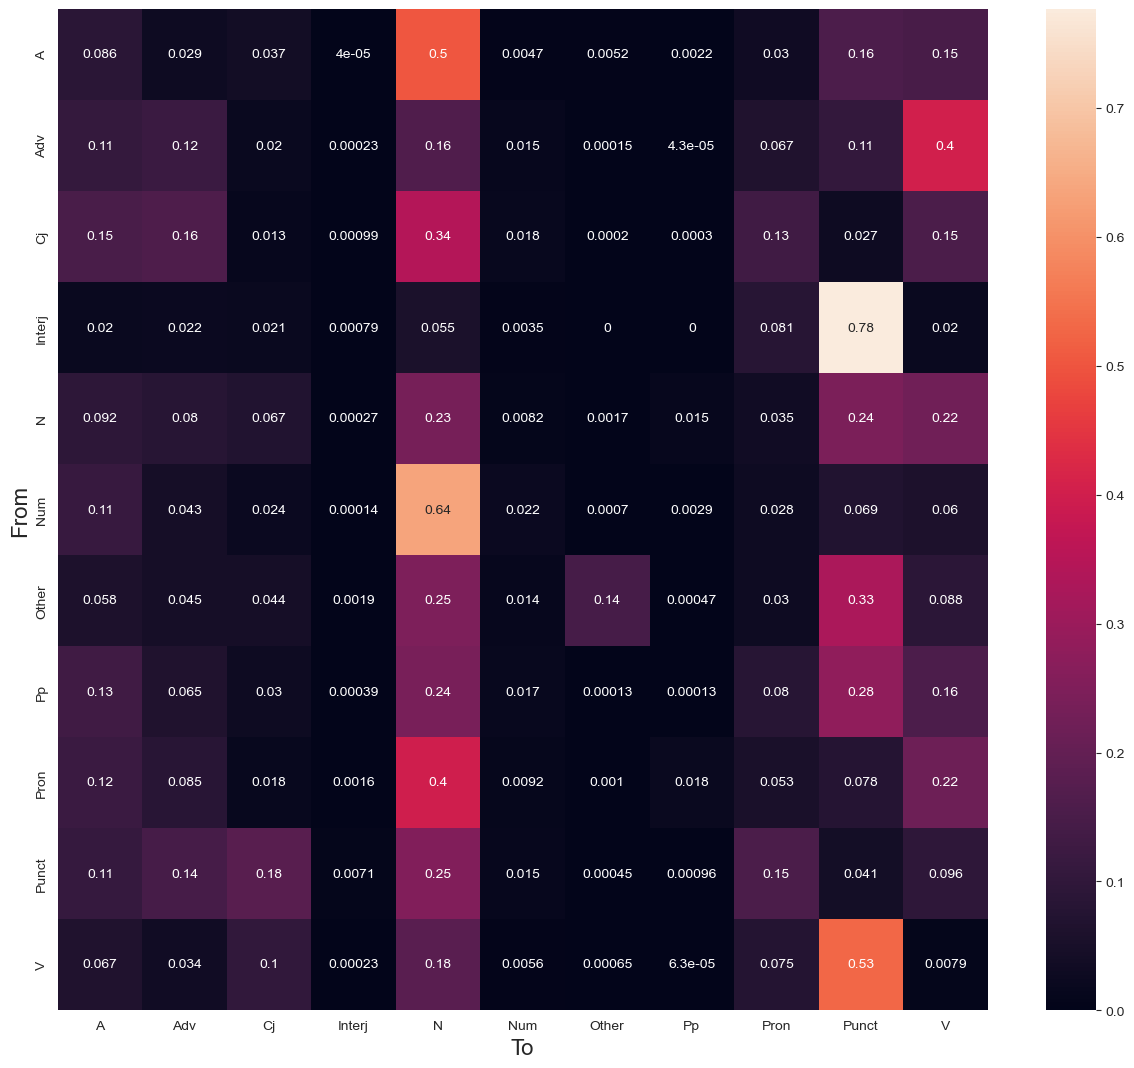

In [44]:
plt.figure(figsize=(15, 13))
sns.heatmap(pd.DataFrame.from_dict(transitions).fillna(0).T, annot=True)
plt.xlabel('To', fontsize=16)
plt.ylabel('From', fontsize=16)
plt.show()

# Model

In [49]:
from hmmlearn import hmm
from sklearn import preprocessing

In [51]:
le = preprocessing.LabelEncoder()
le.fit(pos_tags)

LabelEncoder()

In [53]:
print(le.classes_)

['A' 'Adv' 'Cj' 'Interj' 'N' 'Num' 'Other' 'Pp' 'Pron' 'Punct' 'V']


In [ ]:
model = hmm.CategoricalHMM(n_components=len(pos_tags))
model.startprob_